In [5]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import glob
import os
import sys
sys.path.append('..')
from src.model_UNet import UNet3D
from src.metrics import bce_dice_loss, dice_coefficient, batch_dice_coeff

In [7]:
from src.datasets import KneeSegDataset3D

In [8]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [72]:
# Define data path
DATA_DIR = '../data'

# Get the paths
test_paths = np.array([os.path.basename(i).split('.')[0] for i in glob.glob(f'{DATA_DIR}/test/*.im')])

In [74]:
test_path = test_paths[0]
test_path2 = test_paths[1]

In [38]:
# Load image
import h5py

with h5py.File(os.path.join(DATA_DIR, 'test', test_path + '.im'),'r') as hf:
    img = np.array(hf['data'])
img.shape

(384, 384, 160)

In [75]:
seg_path = os.path.join(DATA_DIR, 'ground-truth', test_path + '.npy')
seg = np.load(seg_path)
seg_path2 = os.path.join(DATA_DIR, 'ground-truth', test_path2 + '.npy')
seg2 = np.load(seg_path2)
seg.shape

(384, 384, 160, 4)

In [84]:
pred_path = os.path.join(DATA_DIR, 'predictions', test_path + '.npy')
pred = np.load(pred_path)
pred_path2 = os.path.join(DATA_DIR, 'predictions', test_path2 + '.npy')
pred2 = np.load(pred_path2)
pred.shape

(1, 5, 256, 264, 160)

In [85]:
pred = np.squeeze(pred, axis=0)  # Shape becomes (5, 256, 264, 160)
pred = np.transpose(pred, (1, 2, 3, 0))[...,1:5]

pred2 = np.squeeze(pred2, axis=0)  # Shape becomes (5, 256, 264, 160)
pred2 = np.transpose(pred2, (1, 2, 3, 0))[...,1:5]
pred.shape

(256, 264, 160, 4)

# Plot Some Stuff

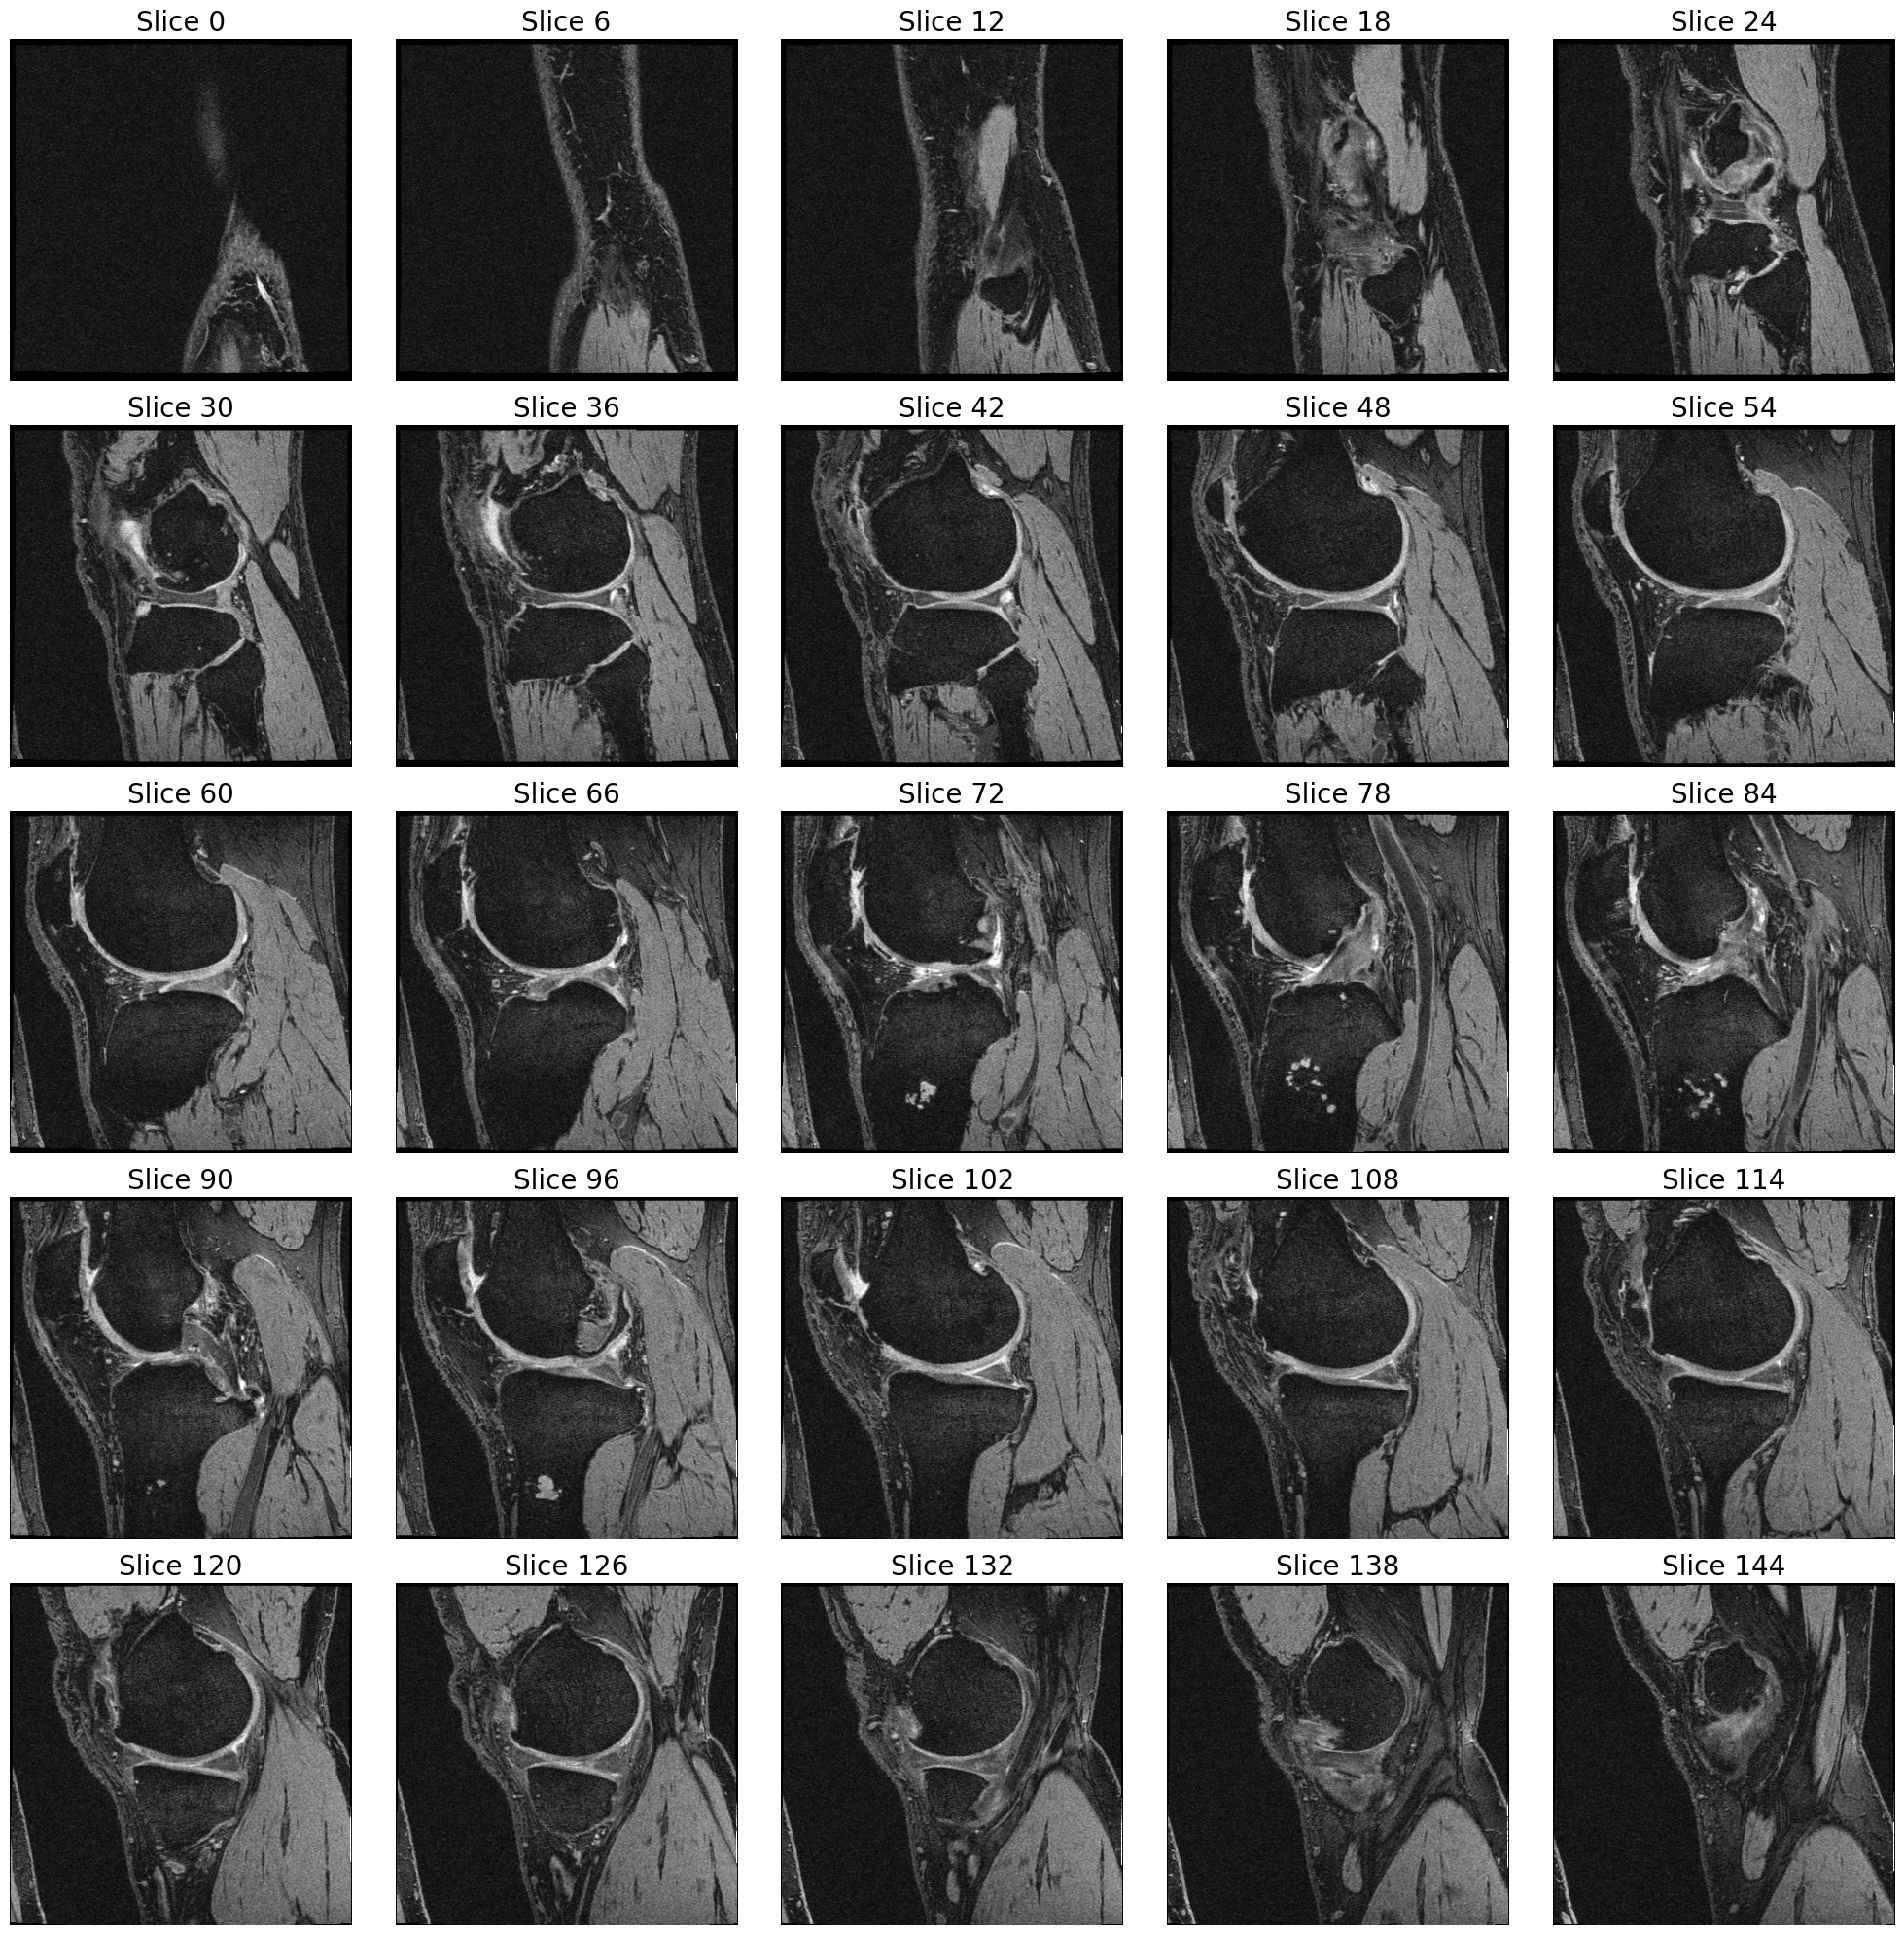

In [59]:
import matplotlib.pyplot as plt

num_subplots = 5
plt.subplots(num_subplots, num_subplots, figsize = (num_subplots*4, num_subplots*4))

for cnt, slnum in enumerate(range(0,img.shape[-1],img.shape[-1]//num_subplots**2)):

    if cnt < num_subplots**2:
    
        plt.subplot(num_subplots, num_subplots, cnt+1)
        plt.imshow(img[...,slnum], vmin = 0, vmax = 0.005, cmap = 'gray')
        plt.title('Slice {}'.format(slnum), fontsize= 20)
        plt.axis('off')
    
plt.tight_layout()
plt.show()

In [86]:
# crop ground truth
seg = seg[56:312,58:322,...]
seg2 = seg2[56:312,58:322,...]

In [88]:
seg2.shape

(256, 264, 160, 4)

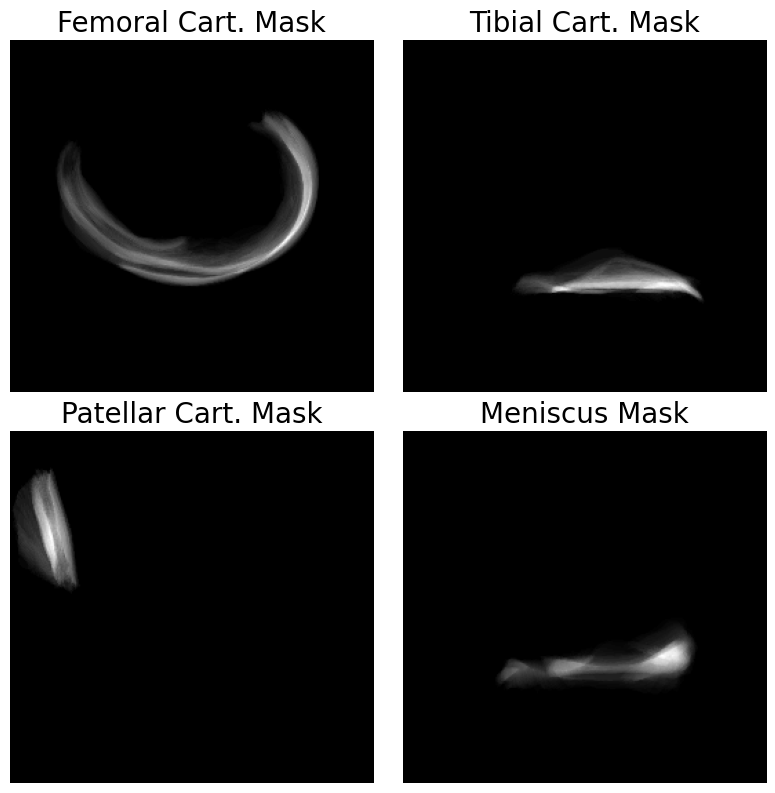

In [92]:
fig_captions = ['Femoral Cart.', 'Tibial Cart.', 'Patellar Cart.', 'Meniscus']
    
nrows = 2
ncols = 2
seg_sums = np.mean(seg2, 2)
plt.subplots(nrows, ncols, figsize = (ncols*4, nrows*4))

for cnt, tis_num in enumerate(range(0,4)):
    plt.subplot(nrows, ncols, cnt+1)
    plt.imshow(seg_sums[...,tis_num], cmap = 'gray')
    plt.title('{} Mask'.format(fig_captions[cnt]), fontsize = 20)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

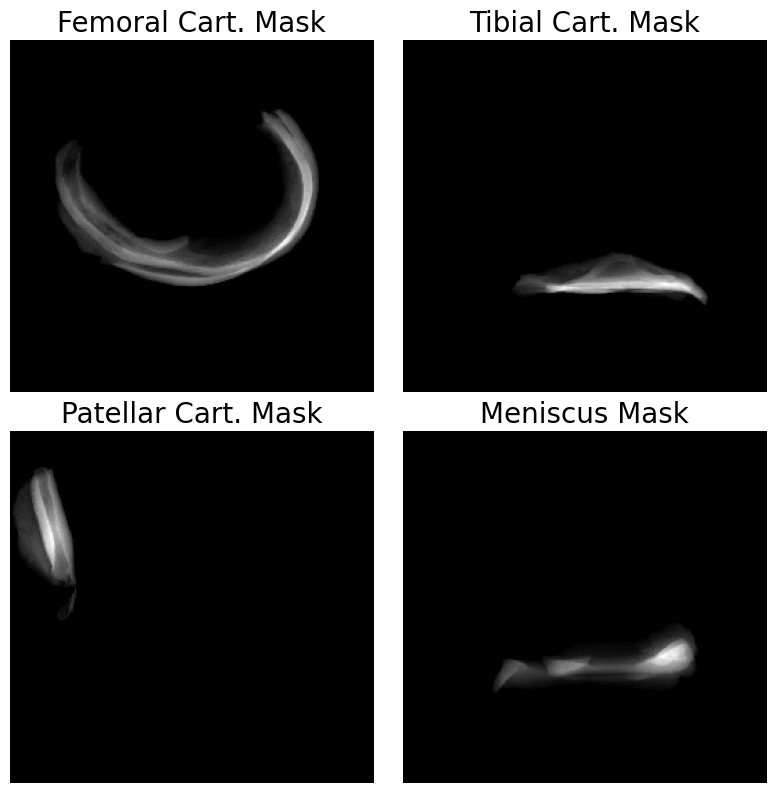

In [93]:
fig_captions = ['Femoral Cart.', 'Tibial Cart.', 'Patellar Cart.', 'Meniscus']
    
nrows = 2
ncols = 2
pred_sums = np.mean(pred2, 2)
plt.subplots(nrows, ncols, figsize = (ncols*4, nrows*4))

for cnt, tis_num in enumerate(range(0,4)):
    plt.subplot(nrows, ncols, cnt+1)
    plt.imshow(pred_sums[...,tis_num], cmap = 'gray')
    plt.title('{} Mask'.format(fig_captions[cnt]), fontsize = 20)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# Check Dice Scores

In [94]:
(pred==pred2).all()

False

In [95]:
for i in range(4):
    seg_channel = seg2[...,i]
    pred_channel = pred2[...,i]
    dice_score = dice_coefficient(torch.from_numpy(seg_channel).float(), torch.from_numpy(pred_channel).float())
    print(f"{fig_captions[i]}: Dice Score {dice_score}")

Femoral Cart.: Dice Score 0.8895688056945801
Tibial Cart.: Dice Score 0.8630415201187134
Patellar Cart.: Dice Score 0.9151148200035095
Meniscus: Dice Score 0.8893964886665344
